# Feature explanations analysis

In [1]:
import src.feature_importance as feim
from itertools import product
from src.utils import set_seeds
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import makedirs
from os.path import exists
from tqdm.notebook import tqdm
# import pickle
import dill
from rdkit import Chem
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

In [2]:
SEED = 42
set_seeds(SEED)

# Defining assessed target and test-training split
dataset_name = "P0DMS8"
trial = 0

SAVE_FIGURES_PATH = f"./data/figures/{dataset_name}/"
SAVE_MAPPING_PATH = f"./data/figures/{dataset_name}/shapley_values_mapping/"

In [3]:
mpl.rcParams.update({'font.size': 12})

## Loading the data

In [4]:
dataset_df = pd.read_csv("./data/dataset.tsv", sep="\t")

In [5]:
dataset_df.pivot_table(index="uniprot_id", columns="label", values="nonstereo_aromatic_smiles", aggfunc="nunique", fill_value=0)

label,active,random
uniprot_id,,
P0DMS8,287,287


In [6]:
dataset_dict = None
fingerprint_gen_dict = None
shap_dict = None
obtained_models = None
with open("./data/pickle/dataset_dict.p", "rb") as infile:
    dataset_dict = dill.load(infile)
with open("./data/pickle/fingerprint_gen_dict.p", "rb") as infile:
    fingerprint_gen_dict = dill.load(infile)
with open("./data/pickle/shap_dict.p", "rb") as infile:
    shap_dict = dill.load(infile)
with open("./data/pickle/obtained_models.p", "rb") as infile:
    obtained_models = dill.load(infile)
prediction_df = pd.read_csv("./data/prediction_df.tsv", sep="\t")

In [7]:
obtained_models

{('P0DMS8',
  0,
  'SVC'): GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.5,
             train_size=None),
              estimator=ExplainingSVC(), n_jobs=-1,
              param_grid={'C': [0.1, 1, 10, 50, 100, 200, 400, 500, 750, 1000],
                          'gamma_value': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
              scoring='neg_mean_squared_error'),
 ('P0DMS8',
  0,
  'RF'): GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.5,
             train_size=None),
              estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
              param_grid={'min_samples_leaf': [1, 2, 5, 10],
                          'min_samples_split': [2, 3, 5, 7, 10],
                          'n_estimators': [10, 100, 250, 500]},
              scoring='neg_mean_squared_error')}

## Model performances

In [8]:
for data_set_name, dataset_grpd_df in prediction_df.groupby(["dataset_name"]):
    for (algorithm, traininset), split_df in prediction_df.groupby(["algorithm", "trainingset"]):
        split_name = "training set" if traininset else "test set"
        print("{} - {}: {:0.2f}".format(algorithm, split_name, balanced_accuracy_score(split_df.label, split_df.prediction)))

RF - test set: 0.92
RF - training set: 1.00
SVC - test set: 0.93
SVC - training set: 1.00


# Analysis

### Setting up variables for analysis

In [9]:
trial_df = prediction_df.query("dataset_name == @dataset_name & trial == @trial")
fingerprint = fingerprint_gen_dict[dataset_name]
dataset = dataset_dict[dataset_name]

svc = obtained_models[(dataset_name, trial, "SVC")].best_estimator_


svc_shapley = shap_dict[(dataset_name, trial, "SVC")]["sverad_values"]
svc_SHAP = shap_dict[(dataset_name, trial, "SVC")]["kernel_shap_values"]
svc_shapley_E = shap_dict[(dataset_name, trial, "SVC")]["expected_value"]
svc_SHAP_E = shap_dict[(dataset_name, trial, "SVC")]["kernel_expected_value"]

rf_shapley = shap_dict[(dataset_name, trial, "RF")]["tree_shap_values"]
rf_SHAP = shap_dict[(dataset_name, trial, "RF")]["kernel_shap_values"]
rf_shapley_E = shap_dict[(dataset_name, trial, "RF")]["expected_value"]
rf_SHAP_E = shap_dict[(dataset_name, trial, "RF")]["kernel_expected_value"]

### Expected values

In [10]:
svc.expected_value

array([-4.6129434])

In [11]:
shap_dict[(dataset_name, trial, "RF")]["expected_value"]

0.49364000000000025

In [12]:
if not exists(SAVE_FIGURES_PATH):
    makedirs(SAVE_FIGURES_PATH)
if not exists(SAVE_MAPPING_PATH):
    makedirs(SAVE_MAPPING_PATH)

### Predicted log-odds of the SVM

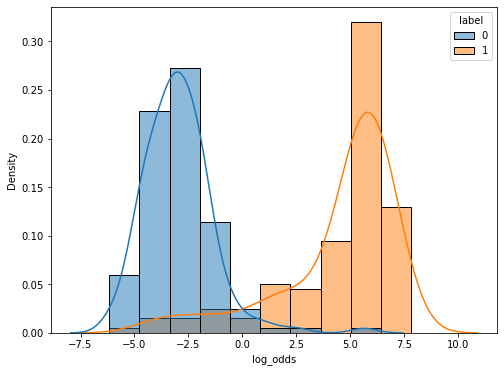

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False)
sns.histplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False, stat="density")
plt.savefig(SAVE_FIGURES_PATH + "predicted_log_odds_SVM.png", dpi=300)

## Absence and presence of features

### Defining assessed compounds and transforming the dataframe for analysis

In [14]:
correct_predicted_df = trial_df.query("label == prediction & testset")

In [15]:
correct_predicted_df_molten = correct_predicted_df.melt(id_vars=["nonstereo_aromatic_smiles", "dataset_idx", "label", "algorithm"],
                                                        value_vars=["present_shap", "absent_shap", "kernel_present_shap", "kernel_absent_shap"],
                                                        value_name="Shapley sum")

In [16]:
# Renaming the columns from 0 and 1 to random and active, respectively.
correct_predicted_df_molten["label_str"] = "Random"
correct_predicted_df_molten.loc[correct_predicted_df_molten["label"] == 1, "label_str"] = "Active"

correct_predicted_df_molten["variable_str"] = ""
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "present_shap", "variable_str"] = "Present features"
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "absent_shap", "variable_str"] = "Absent features"

### SVs for SVM using SVERAD

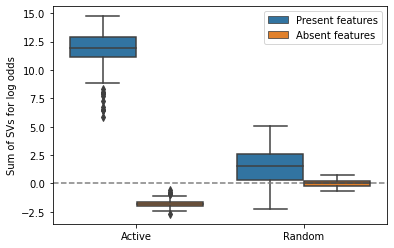

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for log odds")
ax.legend(*ax.get_legend_handles_labels())
plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_sverad_svm.png", dpi=300)

#### Contributions of all features of random compounds.

In [18]:
correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).mean()

1.454511635812159

In [19]:
correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).std()

1.235159344015524

### Kernel-SHAP of SVM
Not part of publication.

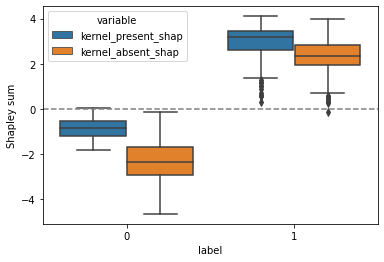

In [20]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_shap_svm_kernel_shap.png", dpi=300)

### SVs for RF using TreeExplainer

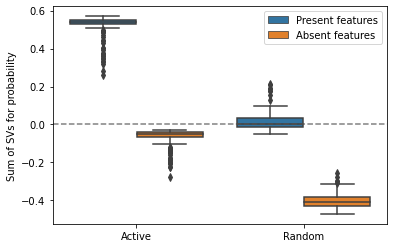

In [21]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for probability")
ax.legend(*ax.get_legend_handles_labels())
plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_SVs_TF_TreeExplainer.png", dpi=300)

### Kernel-SHAP of RF

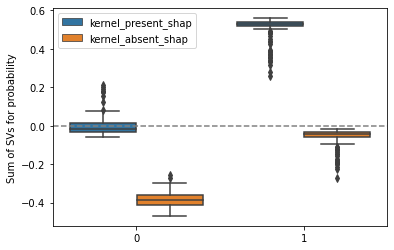

In [22]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("")
ax.set_ylabel(r"Sum of SVs for probability")
ax.legend(*ax.get_legend_handles_labels())
plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_shap_rf_kernel_shap.png")

## Correlation between models and explanations

In [23]:
correlation_df = []
all_contributions = [("SVs SVM", svc_shapley),
                     ("SHAP values SVM", svc_SHAP),
                     ("SVs RF", rf_shapley),
                     ("SHAP values RF", rf_SHAP),
                    ]
for i, row in trial_df.query("algorithm == 'SVC'").iterrows():
    for (alg1, values1), (alg2, values2) in product(all_contributions, repeat=2):
        corr, p = pearsonr(values1[row["dataset_idx"]], values2[row["dataset_idx"]])
        correlation_df.append({"algorithm1": alg1,
                               "algorithm2": alg2,
                               "nonstereo_aromatic_smiles": row["nonstereo_aromatic_smiles"],
                               "label": row["label"],
                               "dataset_idx": row["dataset_idx"],
                               "trainingset": row["trainingset"],

                               "corrleation": corr,
                              })
correlation_df = pd.DataFrame(correlation_df)
correlation_df["pearsons_r_fisher"] = np.arctanh(correlation_df.corrleation)
correlation_df["datasetlabel"] = "Testset"
correlation_df.loc[correlation_df["trainingset"], "datasetlabel"] = "Trainingset"

/home/mastro/anaconda3/envs/sveta/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


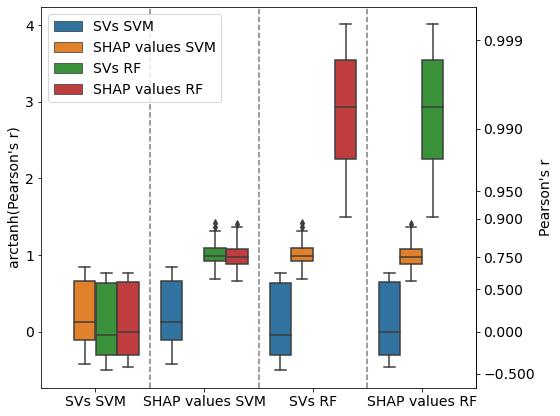

In [24]:
mpl.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'"), x="algorithm1", y="pearsons_r_fisher", hue="algorithm2", hue_order=["SVs SVM", "SHAP values SVM", "SVs RF", "SHAP values RF"])
ylim= ax.get_ylim()
ax.vlines(0.5, *ylim, color="gray", ls="--")
ax.vlines(1.5, *ylim, color="gray", ls="--")
ax.vlines(2.5, *ylim, color="gray", ls="--")
ax.set_ylim(*ylim)
ax.set_xlim(-0.5, 3.5)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]);
ax.set_xlabel("")
ax.legend(*ax.get_legend_handles_labels())
plt.tight_layout()
plt.savefig(SAVE_FIGURES_PATH + "correlation_model_explanations.png", dpi=300)
mpl.rcParams.update({'font.size': 12})

Substituting median with mean below. What do we need?

In [25]:
print("Mean correlation coefficients:")
display(correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="mean").apply(np.tanh))
print("Standard deviation of correlation coefficients:")
display(correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="std").apply(np.tanh))

Mean correlation coefficients:


algorithm2,SHAP values RF,SHAP values SVM,SVs RF,SVs SVM
algorithm1,,,,
SHAP values RF,NaN,0.752305,0.993863,0.127390
SHAP values SVM,0.752305,NaN,0.760898,0.227592
SVs RF,0.993863,0.760898,NaN,0.118826
SVs SVM,0.127390,0.227592,0.118826,NaN


Standard deviation of correlation coefficients:


algorithm2,SHAP values RF,SHAP values SVM,SVs RF,SVs SVM
algorithm1,,,,
SHAP values RF,NaN,0.134336,0.596273,0.429066
SHAP values SVM,0.134336,NaN,0.125936,0.368404
SVs RF,0.596273,0.125936,NaN,0.427885
SVs SVM,0.429066,0.368404,0.427885,NaN


## Mapping of present features
### Selecting the first compound

In [26]:
vis_cpd_idx = 4 #160
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
4,CC(C)(C)NC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,4,1,1,7.088429,0.999166,False,True,0,P0DMS8,SVC,13.837260,-2.135887,3.386163,3.649117
578,CC(C)(C)NC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,4,1,1,NaN,1.000000,False,True,0,P0DMS8,RF,0.539933,-0.033573,0.529513,-0.023153


### SVM explanation

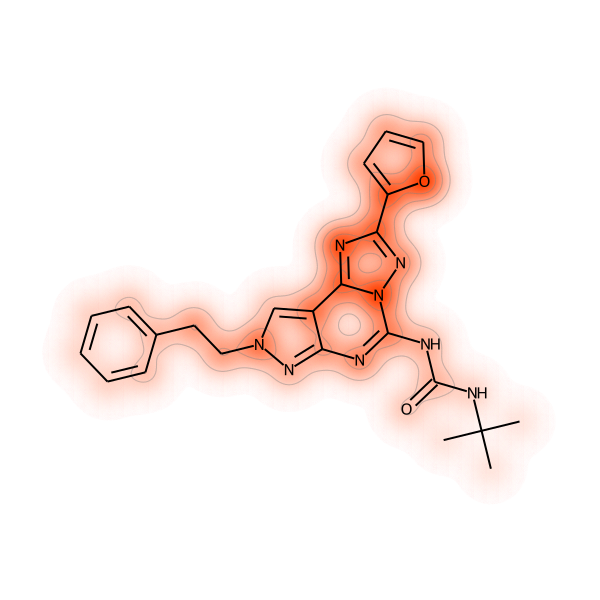

In [27]:
# Creating a RDKit mol object
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
# Determining SVs of present features (absent features cannot be mapped, as they are ... absent)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
# Mapping SVs to atoms
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
# Generating the figure.
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_SVM.png", dpi=(300,300))
display(fig)

### RF explanation

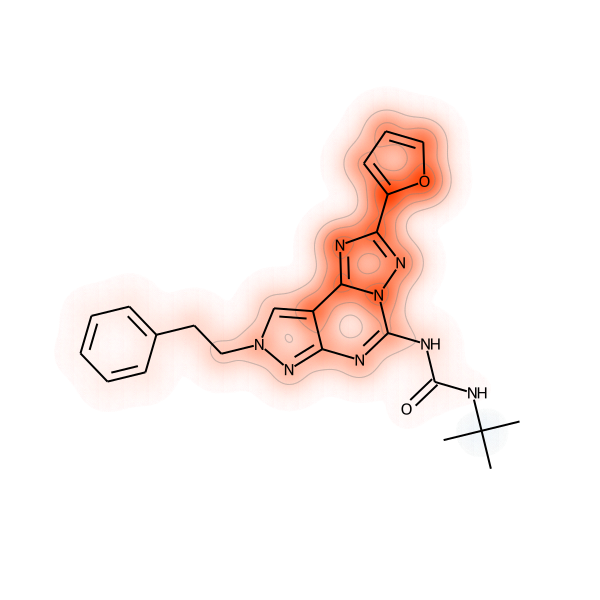

In [28]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_RF.png", dpi=(300,300))
display(fig)

### Selecting the second CPD

In [29]:
vis_cpd_idx = 75
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
75,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,7.92427,0.999638,True,False,0,P0DMS8,SVC,14.810743,-2.273530,4.015991,3.855129
649,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,NaN,1.000000,True,False,0,P0DMS8,RF,0.536943,-0.030583,0.530376,-0.024016


### SVM explanation

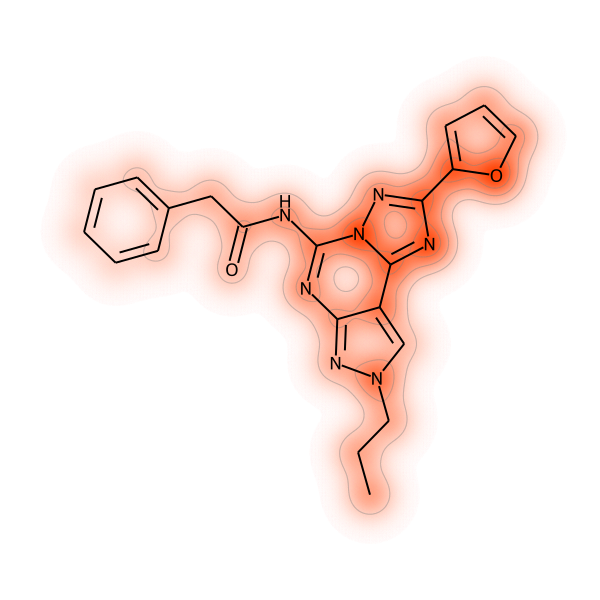

In [30]:
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_SVM.png", dpi=(300,300))
display(fig)

### RF explanation

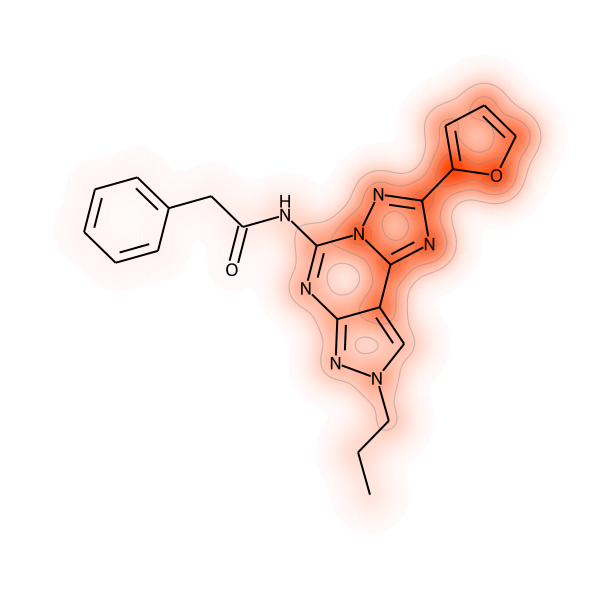

In [31]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_RF.png", dpi=(300,300))
display(fig)

### Generating mapping for all the correctly predicted test cpds

In [32]:

if not exists(SAVE_MAPPING_PATH + "active/"):
    makedirs(SAVE_MAPPING_PATH + "active/")

#for SVERAD SVM
test_active_df_SVM = trial_df.query("testset & label == 1 & prediction == 1 & algorithm == 'SVC'")
for i, row in tqdm(test_active_df_SVM.iterrows(), total=len(test_active_df_SVM)):
    vis_cpd_idx = row["dataset_idx"]
    vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
    vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
    svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
    atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
    svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
    fig = feim.show_png(svg_image.GetDrawingText())
    fig.save(SAVE_MAPPING_PATH + "active/SVM_SVERAD_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))
    
# for TreeExplainer RF
test_active_df_SVM_RF = trial_df.query("testset & label == 1 & prediction == 1 & algorithm == 'RF'")
for i, row in tqdm(test_active_df_SVM_RF.iterrows(), total=len(test_active_df_SVM_RF)):
    vis_cpd_idx = row["dataset_idx"]
    vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
    vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
    svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
    atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
    svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
    fig = feim.show_png(svg_image.GetDrawingText())
    fig.save(SAVE_MAPPING_PATH + "active/RF_TreeSHAP_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [33]:
test_active_df_SVM

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
3,CC(C)(C)NC(=O)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,3,1,1,7.113072,0.999186,False,True,0,P0DMS8,SVC,13.883577,-2.157562,3.401173,3.658749
4,CC(C)(C)NC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,4,1,1,7.088429,0.999166,False,True,0,P0DMS8,SVC,13.837260,-2.135887,3.386163,3.649117
7,CC(C)(C)c1cc(CCNc2ncnc3c2ncn3C2OC(CO)C(O)C2O)c...,7,1,1,5.041894,0.993580,False,True,0,P0DMS8,SVC,11.187916,-1.533079,2.766091,2.222654
12,CC(C)CCn1cc2c(nc(N)n3nc(-c4ccco4)nc23)n1,12,1,1,6.131693,0.997832,False,True,0,P0DMS8,SVC,12.708700,-1.964064,3.288978,2.789565
14,CC(C)CCn1cc2c(nc(NC(=O)CCCNC(=O)OC(C)(C)C)n3nc...,14,1,1,5.350461,0.995276,False,True,0,P0DMS8,SVC,11.820917,-1.857513,2.658266,2.639045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,OCC1OC(n2cnc3c(NC4CCCC4)ncnc32)C(O)C1O,280,1,1,6.238353,0.998051,False,True,0,P0DMS8,SVC,12.464647,-1.613350,3.302218,2.882986
281,OCC1OC(n2cnc3c(NCc4cccc(I)c4)nc(Cl)nc32)C(O)C1O,281,1,1,6.705291,0.998777,False,True,0,P0DMS8,SVC,13.075304,-1.757070,3.483699,3.168443
282,OCC1OC(n2cnc3c(NCc4cccc(I)c4)ncnc32)C(O)C1O,282,1,1,6.512511,0.998517,False,True,0,P0DMS8,SVC,12.754627,-1.629173,3.657567,2.801795
283,OCC1OC(n2cnc3c(NCc4ccccc4)ncnc32)C(O)C1O,283,1,1,7.124316,0.999195,False,True,0,P0DMS8,SVC,13.386599,-1.649339,3.831682,3.239485


In [34]:

if not exists(SAVE_MAPPING_PATH + "random/"):
    makedirs(SAVE_MAPPING_PATH + "random/")

#for SVERAD SVM
test_random_df_SVM = trial_df.query("testset & label == 0 & prediction == 0 & algorithm == 'SVC'")
for i, row in tqdm(test_random_df_SVM.iterrows(), total=len(test_random_df_SVM)):
    vis_cpd_idx = row["dataset_idx"]
    vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
    vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
    svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
    atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
    svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
    fig = feim.show_png(svg_image.GetDrawingText())
    fig.save(SAVE_MAPPING_PATH + "random/SVM_SVERAD_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))
    
# for TreeExplainer RF
test_random_df_RF = trial_df.query("testset & label == 0 & prediction == 0 & algorithm == 'RF'")
for i, row in tqdm(test_random_df_RF.iterrows(), total=len(test_random_df_RF)):
    vis_cpd_idx = row["dataset_idx"]
    vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
    vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
    svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
    atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
    svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
    fig = feim.show_png(svg_image.GetDrawingText())
    fig.save(SAVE_MAPPING_PATH + "random/RF_TreeSHAP_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]